numerical:
[[ 0.    1.  ]
 [ 0.   -0.15]]
[[0.]
 [3.]]
true:
[[ 0.    1.  ]
 [ 0.   -0.15]]
[[0.]
 [3.]]


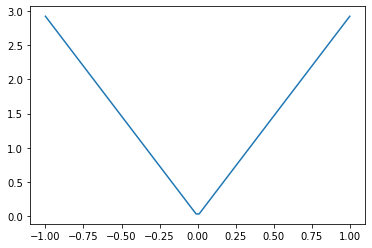

In [17]:
import scipy
from scipy.interpolate import CubicHermiteSpline, PPoly, interp1d
from scipy.integrate import solve_ivp, ode, odeint
import jax
import pickle
import numpy as np
import matplotlib.pyplot as plt

def dynamics(x, u):
    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    MIN_W, MAX_W = -7., 7

    MIN_TORQUE, MAX_TORQUE = -1., 1.

    LENGTH = 1.
    MASS = 1.
    DAMPING = .05
    gravity_coeff = MASS*9.81*LENGTH*0.5
    integration_coeff = 3. / (MASS*LENGTH*LENGTH)
    res = np.zeros(2)
    res[0] = x[1]
    res[1] = integration_coeff * (u[0] - gravity_coeff*np.cos(x[0]) - DAMPING*x[1])
    if res[0] < -np.pi:
        res[0] += 2*np.pi
    elif res[0] > np.pi:
        res[0] -= 2 * np.pi
    res = np.clip(res, [MIN_ANGLE, MIN_W], [MAX_ANGLE, MAX_W])
    return res


def jax_dynamics(x, u):
    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    MIN_W, MAX_W = -7., 7

    MIN_TORQUE, MAX_TORQUE = -1., 1.

    LENGTH = 1.
    MASS = 1.
    DAMPING = .05
    gravity_coeff = MASS*9.81*LENGTH*0.5
    integration_coeff = 3. / (MASS*LENGTH*LENGTH)
    #res = jax.numpy.zeros(2)
    #res[0] = x[1]
    #res[1] = integration_coeff * (u[0] - gravity_coeff*jax.numpy.cos(x[0]) - DAMPING*x[1])
    return jax.numpy.asarray([x[1],integration_coeff * (u[0] - gravity_coeff*jax.numpy.cos(x[0]) - DAMPING*x[1])])

def true_linear(x, u):
    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    MIN_W, MAX_W = -7., 7

    MIN_TORQUE, MAX_TORQUE = -1., 1.

    LENGTH = 1.
    MASS = 1.
    DAMPING = .05
    gravity_coeff = MASS*9.81*LENGTH*0.5
    integration_coeff = 3. / (MASS*LENGTH*LENGTH)
    A = np.zeros((2,2))
    A[0,0] = 0
    A[0,1] = 1.
    A[1,0] = integration_coeff*gravity_coeff*np.sin(x[0])
    A[1,1] = -integration_coeff*DAMPING
    B = np.zeros((2,1))
    B[0,0] = 0
    B[1,0] = integration_coeff
    return A,B
 


def jaxfunc(x, u):
    return jax.numpy.asarray(jax_dynamics(x, u))

def linearization(x, u):
    A = jax.jacfwd(jaxfunc, argnums=0)(x, u)
    B = jax.jacfwd(jaxfunc, argnums=1)(x, u)
    return A, B
    
# read the data obtained from sparse_rrt
f = open('../../data/pendulum/path_0.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
x = p.load()
f = open('../../data/pendulum/control_0.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
u = p.load()
u = u.reshape(len(u),1)
f = open('../../data/pendulum/cost_0.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
dt = p.load()

# see if the linearization is working fine
direction = np.random.normal(size=3)
direction = direction / np.linalg.norm(direction)
epsilon = np.linspace(-1, 1, 100)

x = x[2]
#u = np.array([u[5]])
u = u[2]
x = np.array([0.,0.])
u = np.array([0.])
state = np.array([x[0], x[1], u[0]])
# linearlize around this point
approx_error = []
for i in range(len(epsilon)):
    new_state = direction * epsilon[i] + state
    new_x = new_state[:2]
    new_u = np.array([new_state[2]])
    true_dx = dynamics(new_x, new_u)
    A, B = linearization(x, u)
    approx_dx = dynamics(x, u) + A @ (new_x - x) + B @ (new_u - u)
    approx_error.append(np.linalg.norm(approx_dx - true_dx))
plt.plot(epsilon, approx_error)


true_A, true_B = true_linear(x, u)
print('numerical:')
print(A)
print(B)
print('true:')
print(true_A)
print(true_B)
